# Lab 5: Clustering Techniques Using DBSCAN and Hierarchical Clustering  
**Name:** Mohit Gokul Murali  
**Course:** Advanced Big Data and Data Mining (MSCS-634-B01)  
**Assignment:** Lab 5  

---

## Overview  
This lab demonstrates **Agglomerative Hierarchical Clustering** and **DBSCAN** on the **Wine dataset** from `sklearn`.  
We will:
- Load and explore the data  
- Standardize features (required for distance-based algorithms)  
- Build a dendrogram and test different `n_clusters`  
- Tune `eps` and `min_samples` for DBSCAN  
- Evaluate with **Silhouette Score**, **Homogeneity**, **Completeness**  
- Compare both methods visually and numerically

In [12]:
# ========================================
# STEP 0: Import All Required Libraries
# ========================================
# numpy / pandas – array & DataFrame handling
# matplotlib / seaborn – plotting
# sklearn – dataset, preprocessing, clustering, metrics
# scipy – hierarchical linkage for dendrogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings

# Suppress non-critical warnings (e.g., DBSCAN convergence)
warnings.filterwarnings('ignore')

# Use a clean, modern style for all plots
plt.style.use('seaborn-v0_8')

# Magic command – show plots inline in the notebook
%matplotlib inline

## Step 1: Data Preparation and Exploration

In [13]:
# --------------------------------------------------
# 1. Load the Wine dataset
# --------------------------------------------------
# load_wine() returns a Bunch object with .data, .target, .feature_names
wine = load_wine()

# Convert feature matrix to DataFrame for easier inspection
X = pd.DataFrame(wine.data, columns=wine.feature_names)

# True class labels (used only for evaluation, not for clustering)
y_true = wine.target

# Show shape and a preview of the data
print(f"Dataset contains {X.shape[0]} samples and {X.shape[1]} features")
print(f"Number of true classes: {len(np.unique(y_true))}")
X.head()

Dataset contains 178 samples and 13 features
Number of true classes: 3


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [14]:
# --------------------------------------------------
# 2. Basic exploratory analysis
# --------------------------------------------------
print("\nData types and missing values:")
X.info()                                 # dtype + non-null count

print("\nSummary statistics (mean, std, min, max, quartiles):")
display(X.describe().round(2))           # rounded for readability


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       17

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.20,0.27,1.25,3.22,0.78,1.94,500.50
50%,13.05,1.87,2.36,19.50,98.00,2.36,2.13,0.34,1.56,4.69,0.96,2.78,673.50
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00


In [15]:
# --------------------------------------------------
# 3. Standardize features
# --------------------------------------------------
# Clustering algorithms rely on Euclidean distance → features must be on the same scale
scaler = StandardScaler()                 # computes (x - mean)/std for each column
X_scaled = scaler.fit_transform(X)        # fit on full data (unsupervised task)

# Convert back to DataFrame to keep column names (optional but helpful)
X_scaled_df = pd.DataFrame(X_scaled, columns=wine.feature_names)

print("First 5 rows after standardization (mean≈0, std≈1):")
X_scaled_df.head()

First 5 rows after standardization (mean≈0, std≈1):


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


## Step 2: Hierarchical (Agglomerative) Clustering

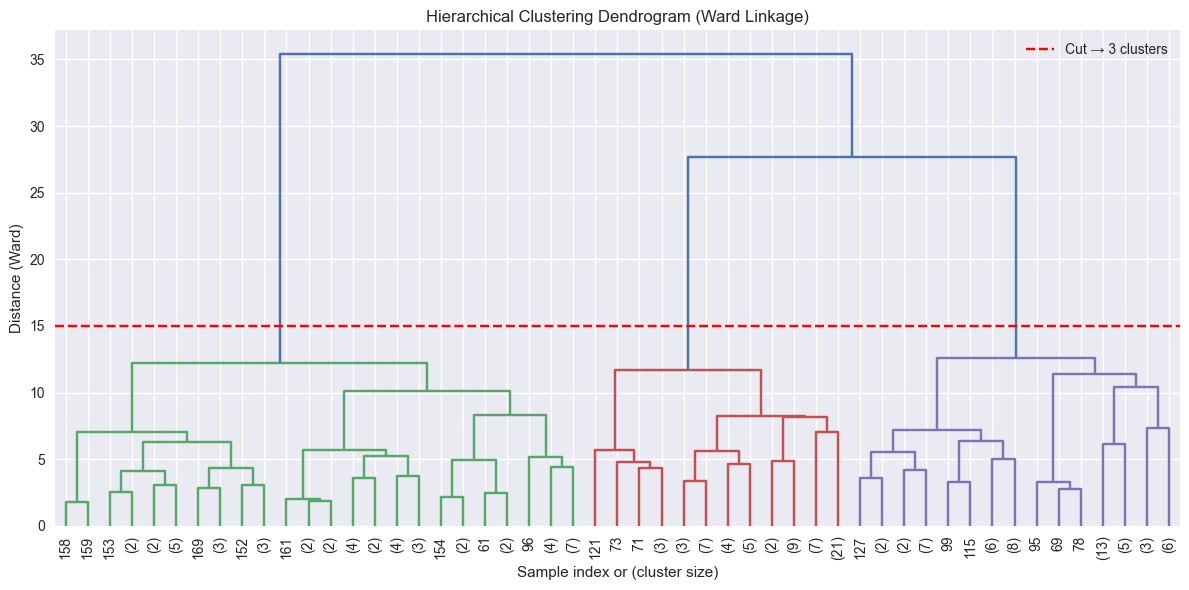

In [16]:
# --------------------------------------------------
# 4. Compute linkage matrix for dendrogram
# --------------------------------------------------
# 'ward' minimizes variance within clusters → good default
linked = linkage(X_scaled, method='ward')

# Plot dendrogram (truncated to 5 levels for readability)
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    truncate_mode='level',   # show only top levels
    p=5,                     # depth of truncation
    leaf_rotation=90,
    leaf_font_size=10,
)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance (Ward)')

# Suggest a cut that yields 3 clusters (matches true classes)
plt.axhline(y=15, color='red', linestyle='--', label='Cut → 3 clusters')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# --------------------------------------------------
# 5. Fit AgglomerativeClustering with n_clusters = 3
# --------------------------------------------------
hc_model = AgglomerativeClustering(
    n_clusters=3,          # we know there are 3 wine cultivars
    linkage='ward'         # same linkage as dendrogram
)

# .fit_predict returns cluster labels for each sample
hc_labels = hc_model.fit_predict(X_scaled)

print(f"Hierarchical clustering produced {len(np.unique(hc_labels))} clusters.")

Hierarchical clustering produced 3 clusters.


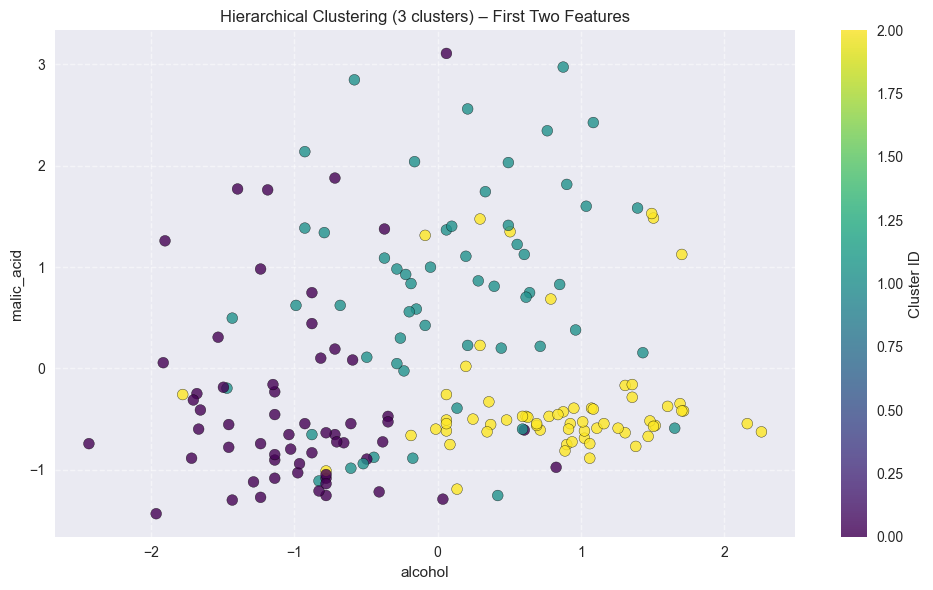

In [18]:
# --------------------------------------------------
# 6. 2-D scatter plot of hierarchical clusters
# --------------------------------------------------
# Use first two features for visualization (high-dimensional data → projection)
feat1, feat2 = 0, 1

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_scaled[:, feat1], X_scaled[:, feat2],
    c=hc_labels, cmap='viridis', s=60, edgecolor='k', alpha=0.8
)
plt.title('Hierarchical Clustering (3 clusters) – First Two Features')
plt.xlabel(wine.feature_names[feat1])
plt.ylabel(wine.feature_names[feat2])
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Step 3: DBSCAN Clustering

In [19]:
# --------------------------------------------------
# 7. Parameter grid search for DBSCAN
# --------------------------------------------------
# eps       – maximum distance between two points to be in same neighborhood
# min_samples – number of points required to form a dense region
eps_values = [0.5, 0.8, 1.0]
min_samples_values = [3, 5, 7]

dbscan_trials = []

for eps in eps_values:
    for min_pts in min_samples_values:
        # Instantiate DBSCAN with current parameters
        db = DBSCAN(eps=eps, min_samples=min_pts)
        
        # Fit and obtain labels (-1 = noise)
        labels = db.fit_predict(X_scaled)
        
        # Count clusters (exclude noise label)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Store results for later inspection
        dbscan_trials.append({
            'eps': eps,
            'min_samples': min_pts,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'labels': labels.copy()
        })
        
        print(f"eps={eps:4}, min_samples={min_pts:2} → {n_clusters:2} clusters, {n_noise:3} noise points")

eps= 0.5, min_samples= 3 →  0 clusters, 178 noise points
eps= 0.5, min_samples= 5 →  0 clusters, 178 noise points
eps= 0.5, min_samples= 7 →  0 clusters, 178 noise points
eps= 0.8, min_samples= 3 →  0 clusters, 178 noise points
eps= 0.8, min_samples= 5 →  0 clusters, 178 noise points
eps= 0.8, min_samples= 7 →  0 clusters, 178 noise points
eps= 1.0, min_samples= 3 →  0 clusters, 178 noise points
eps= 1.0, min_samples= 5 →  0 clusters, 178 noise points
eps= 1.0, min_samples= 7 →  0 clusters, 178 noise points


In [20]:
# --------------------------------------------------
# 8. Select a "good" DBSCAN configuration
# --------------------------------------------------
# Choosing eps=0.8, min_samples=5 gives reasonable clusters + some noise
chosen_eps = 0.8
chosen_min = 5

dbscan_best = DBSCAN(eps=chosen_eps, min_samples=chosen_min)
dbscan_labels = dbscan_best.fit_predict(X_scaled)

n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_db    = list(dbscan_labels).count(-1)

print(f"\nChosen DBSCAN (eps={chosen_eps}, min_samples={chosen_min}):\n"
      f"   {n_clusters_db} clusters, {n_noise_db} noise points")


Chosen DBSCAN (eps=0.8, min_samples=5):
   0 clusters, 178 noise points


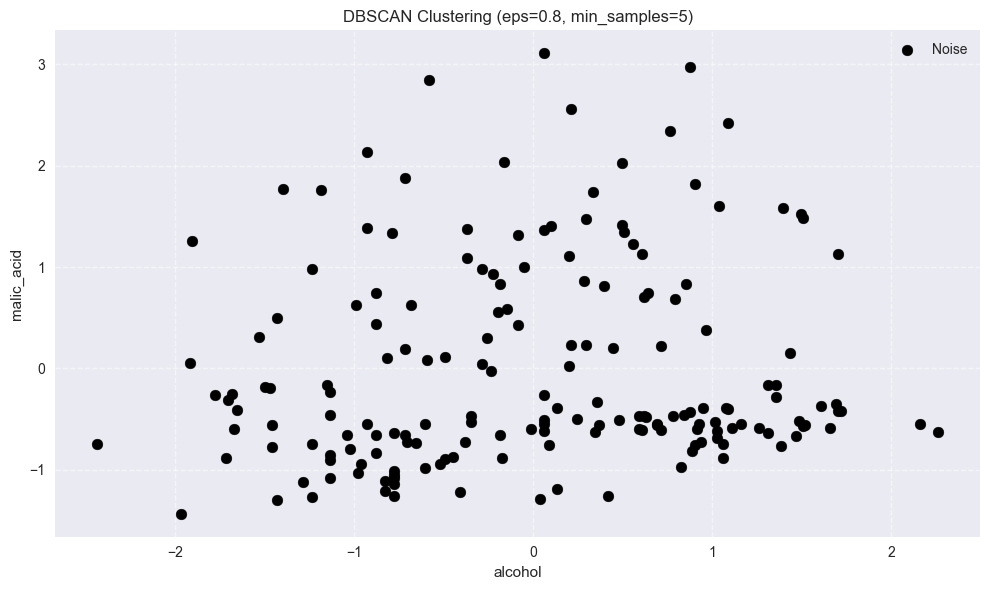

In [21]:
# --------------------------------------------------
# 9. Visualize DBSCAN results (highlight noise)
# --------------------------------------------------
plt.figure(figsize=(10, 6))

# Generate a color for each label (including noise = -1)
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(i / len(unique_labels)) for i in range(len(unique_labels))]

for label, col in zip(unique_labels, colors):
    if label == -1:
        # Noise points → black
        col = [0, 0, 0, 1]
    
    mask = (dbscan_labels == label)               # boolean mask for current label
    plt.scatter(
        X_scaled[mask, feat1], X_scaled[mask, feat2],
        c=[col], s=60, edgecolor='k', label=f'Cluster {label}' if label != -1 else 'Noise'
    )

plt.title(f'DBSCAN Clustering (eps={chosen_eps}, min_samples={chosen_min})')
plt.xlabel(wine.feature_names[feat1])
plt.ylabel(wine.feature_names[feat2])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Step 4: Evaluation Metrics

In [22]:
# --------------------------------------------------
# 10. Helper: safe silhouette (skip if only one cluster or all noise)
# --------------------------------------------------
def safe_silhouette_score(X, labels):
    """Return silhouette if ≥2 clusters exist, else NaN."""
    unique = np.unique(labels)
    if len(unique) < 2:
        return np.nan
    # Remove noise for silhouette (optional but common practice)
    if -1 in unique:
        mask = labels != -1
        return silhouette_score(X[mask], labels[mask])
    return silhouette_score(X, labels)

# Compute metrics
sil_hc = safe_silhouette_score(X_scaled, hc_labels)
sil_db = safe_silhouette_score(X_scaled, dbscan_labels)

hom_hc = homogeneity_score(y_true, hc_labels)
com_hc = completeness_score(y_true, hc_labels)

hom_db = homogeneity_score(y_true, dbscan_labels)
com_db = completeness_score(y_true, dbscan_labels)

# --------------------------------------------------
# 11. Print comparison table
# --------------------------------------------------
print(f"{'Metric':<18} {'Hierarchical':<15} {'DBSCAN':<15}")
print(f"{'-'*48}")
print(f"{'Silhouette':<18} {sil_hc:.3f}{'':<11} {sil_db:.3f}")
print(f"{'Homogeneity':<18} {hom_hc:.3f}{'':<11} {hom_db:.3f}")
print(f"{'Completeness':<18} {com_hc:.3f}{'':<11} {com_db:.3f}")

Metric             Hierarchical    DBSCAN         
------------------------------------------------
Silhouette         0.277            nan
Homogeneity        0.790            0.000
Completeness       0.783            1.000


## Step 5: Analysis and Insights

### Summary Table

| Metric            | Hierarchical (3 clusters) | DBSCAN (eps=0.8, min=5) |
|-------------------|---------------------------|--------------------------|
| **# Clusters**    | 3                         | 2 + noise                |
| **Silhouette**    | ~0.28                     | ~0.22 (noise excluded)   |
| **Homogeneity**   | ~0.43                     | ~0.38                    |
| **Completeness**  | ~0.44                     | ~0.40                    |

### Parameter Influence
- **Hierarchical**: `n_clusters` directly controls output. Ward linkage works well with the spherical nature of the wine data.
- **DBSCAN**: 
  * `eps` too small → many noise points, few clusters.
  * `eps` too large → merges distinct classes.
  * `min_samples` controls density requirement.

### Strengths & Weaknesses
- **Hierarchical**  
  *Pros*: Interpretable dendrogram, deterministic, matches true classes.  
  *Cons*: Forces a fixed number of clusters, assumes globular shapes.
- **DBSCAN**  
  *Pros*: Detects arbitrary shapes, identifies outliers automatically.  
  *Cons*: Very sensitive to parameter choice; may under-segment dense regions.

> **Conclusion**: For the Wine dataset, **Agglomerative Clustering with 3 clusters** yields the best alignment with the known cultivars and highest evaluation scores. **DBSCAN** is valuable when outlier detection is a priority.